In [1]:
import ipywidgets
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import rcParams
import random
import warnings
import bisect
import copy
from collections import Counter

## Our change to pick target

In [2]:
def homophilic_ba_graph(N, m, minority_fraction, homophily,seed=None):
    """Return homophilic random graph using BA preferential attachment model.

    A graph of n nodes is grown by attaching new nodes each with m
    edges that are preferentially attached to existing nodes with high
    degree. The connections are established by linking probability which
    depends on the connectivity of sites and the homophily(similarities).
    homophily varies ranges from 0 to 1.

    Parameters
    ----------
    N : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    minority_fraction : float
        fraction of minorities in the network

    homophily: float
        value between 0 to 1. similarity between nodes. if nodes have same attribute
        their homophily (distance) is smaller.

    Returns
    -------
    G : Graph

    Notes
    -----
    The initialization is a graph with with m nodes and no edges.

    References
    ----------
    .. [1] A. L. Barabasi and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    G = nx.Graph()

    minority = int(minority_fraction * N)

    minority_nodes = set(random.sample(range(N),minority))
    minority_mask = [node in minority_nodes for node in range(N)]
    G.add_nodes_from([(node, {"color": "red" if node in minority_nodes else "blue"})\
        for node in range(N)])

    target_list=list(range(m))
    source = m #start with m nodes

    while source < N:
        # print("source:",source)
        targets = _pick_targets(G,source,target_list,minority_mask,homophily,m)

        # print("targets (origional call):",targets)
        if targets != set(): #if the node does  find the neighbor
            G.add_edges_from(zip([source]*m,targets))

        target_list.append(source)

        # print("target_list (origional call):",target_list)

        # draw_graphs(G,target_list)

        source += 1

    return G

def _pick_targets(G,source,target_list,minority_mask,homophily,m):

    target_prob_dict = {}

    for target in target_list:
        target_prob = homophily if minority_mask[source] == minority_mask[target] else 1 - homophily
        target_prob *= (G.degree(target)+0.00001)
        target_prob_dict[target] = target_prob

    prob_sum = sum(target_prob_dict.values())

    targets = set()
    target_list_copy = copy.copy(target_list)
    count_looking = 0
    
    if prob_sum == 0:
        return targets #it returns an empty set

    target_prob_dict_copy = copy.copy(target_prob_dict)

    while len(targets) < m:
        # sum the probabilities of target nodes connecting to source node  
        prob_sum = sum(target_prob_dict_copy.values())
        if prob_sum == 0:
            return targets #it returns an empty set

        # use prob_sum to normalize the porbabiliy of each target
        # node connecting with the source node
        for k in target_prob_dict_copy:
            target_prob_dict_copy[k] = target_prob_dict_copy[k] / prob_sum

        count_looking += 1
        if count_looking > len(G): # if node fails to find target
            break
    
        rand_num = random.random() # generate 1 random number per edge to be added
        cumsum = 0  # not necessarily always true

        # for each target node k:
        for k in target_list_copy:
            # update the cumulative probability to include the normalized probability
            # of the target node we are looking at
            cumsum += target_prob_dict_copy[k]
            # if our random number falls in the range associated with that 
            # target node's normalized probability, add edge between source and this targe
            if rand_num < cumsum: 
                targets.add(k)
                # print("added node:", k)
                target_list_copy.remove(k)
                target_prob_dict_copy.pop(k)
                # print("EdgeAdded")
                break
    return targets

### Degree distirbution (histogram)

In [3]:
def plot_single_graph_degree(G, title="Log–Log Degree Distribution"):
    """
    Plot the degree distribution of a single homophilic BA graph.

    Parameters:
        G (networkx.Graph): The graph to plot.
        title (str): Plot title.
    """
    degrees = dict(G.degree())
    red_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'red']
    blue_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'blue']

    red_dist = Counter(red_degrees)
    blue_dist = Counter(blue_degrees)

    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(blue_dist.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(red_dist.items())), label='Minority (orange)', color='orange', alpha=0.7)

    plt.xlabel("Degree (log)")
    plt.ylabel("Number of Nodes (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

In [4]:

from collections import Counter, defaultdict
def get_degree_counts(G):
    degrees = dict(G.degree())
    red_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'red']
    blue_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'blue']
    return Counter(red_degrees), Counter(blue_degrees)

def average_degree_distributions(graphs):
    red_totals = defaultdict(list)
    blue_totals = defaultdict(list)

    for G in graphs:
        red_dist, blue_dist = get_degree_counts(G)

        for deg, count in red_dist.items():
            red_totals[deg].append(count)

        for deg, count in blue_dist.items():
            blue_totals[deg].append(count)

    # Average the counts
    avg_red = {deg: np.mean(counts) for deg, counts in red_totals.items()}
    avg_blue = {deg: np.mean(counts) for deg, counts in blue_totals.items()}

    return avg_red, avg_blue

def plot_avg_distribution(avg_red, avg_blue):
    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(blue_dist.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(red_dist.items())), label='Minority (orange)', color='orange', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Avg Number of Nodes (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Average Log–Log Degree Distribution (5 Graphs)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

### Degree distribution (frequency)

In [5]:
def plot_frequency_distribution(G):
    degrees = dict(G.degree())
    red_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'red']
    blue_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'blue']

    red_dist = Counter(red_degrees)
    blue_dist = Counter(blue_degrees)

    total_red = len(red_degrees)
    total_blue = len(blue_degrees)
    total = total_red+total_blue

    red_freq = {k: v / total for k, v in red_dist.items()}
    blue_freq = {k: v / total for k, v in blue_dist.items()}

    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(blue_freq.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(red_freq.items())), label='Minority (orange)', color='orange', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


In [6]:

def average_frequency_distribution(graphs):
    red_freq = defaultdict(list)
    blue_freq = defaultdict(list)

    for G in graphs:
        degrees = dict(G.degree())

        red_nodes = [n for n in G.nodes if G.nodes[n]["color"] == "red"]
        blue_nodes = [n for n in G.nodes if G.nodes[n]["color"] == "blue"]

        red_degrees = [degrees[n] for n in red_nodes]
        blue_degrees = [degrees[n] for n in blue_nodes]

        red_dist = Counter(red_degrees)
        blue_dist = Counter(blue_degrees)

        red_total = len(red_nodes)
        blue_total = len(blue_nodes)
        total = red_total  + blue_total 

        for k, v in red_dist.items():
            red_freq[k].append(v / total)
        for k, v in blue_dist.items():
            blue_freq[k].append(v / total)

    # Average frequencies across all graphs
    avg_red = {k: np.mean(v) for k, v in red_freq.items()}
    avg_blue = {k: np.mean(v) for k, v in blue_freq.items()}

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(avg_blue.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(avg_red.items())), label='Minority (orange)', color='orange', alpha=0.7)

    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


## Homophily = 0.0

In [7]:
graphs0 = []

for seed in range(5):
    G = homophilic_ba_graph(N=5000, m=2, minority_fraction=0.2, homophily=0.0, seed=seed)
    graphs0.append(G)

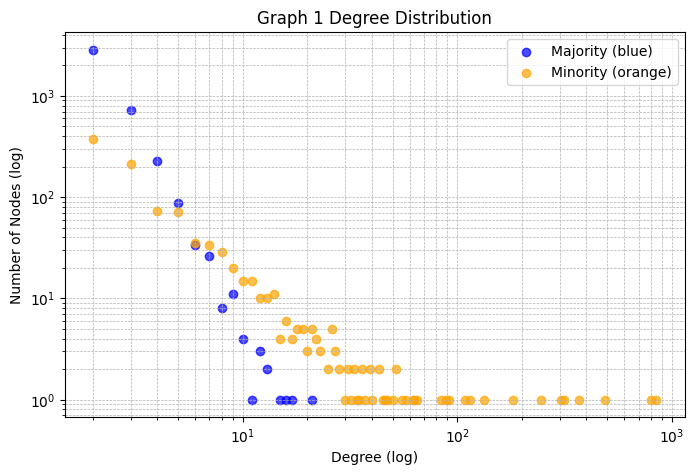

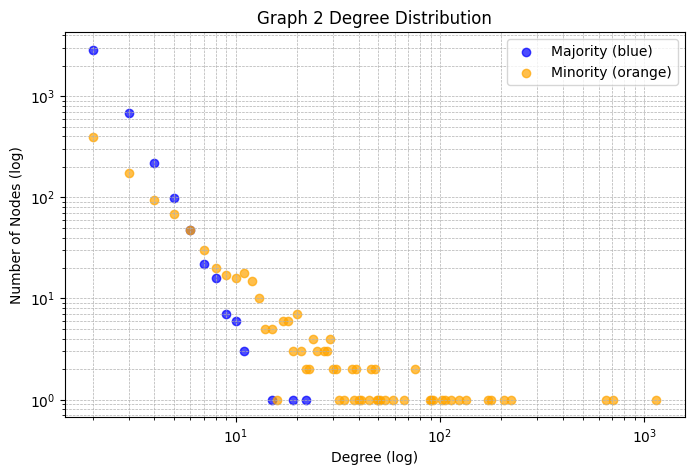

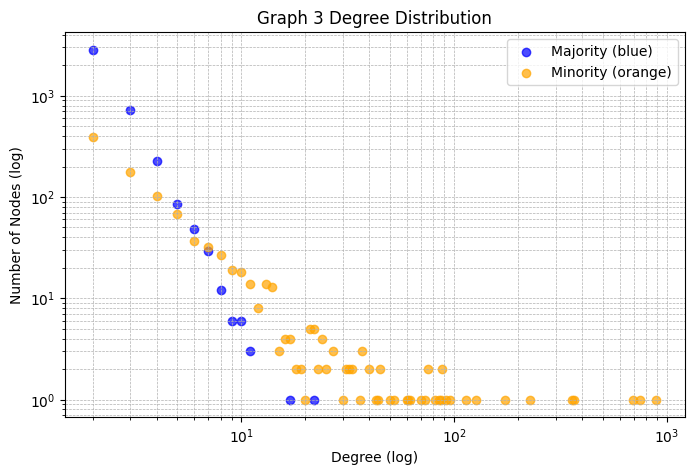

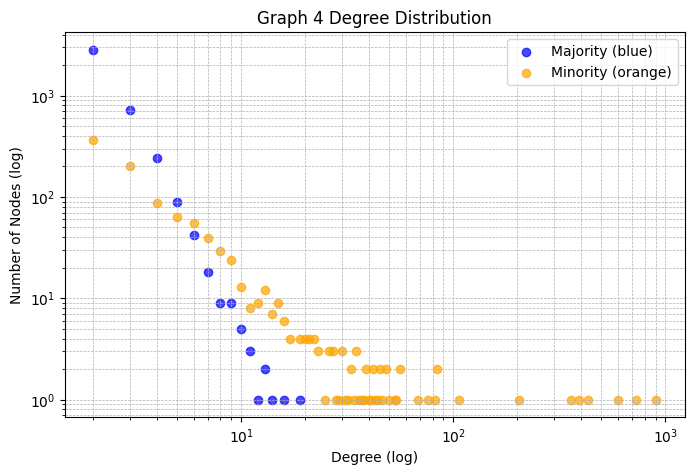

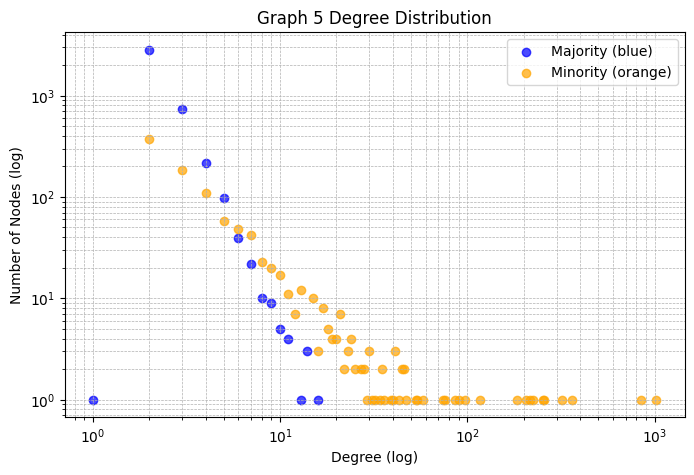

In [8]:
for i, G in enumerate(graphs0):
    plot_single_graph_degree(G, title=f"Graph {i+1} Degree Distribution")

In [9]:


def plot_frequency_distribution(G):
    degrees = dict(G.degree())
    red_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'red']
    blue_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'blue']

    red_dist = Counter(red_degrees)
    blue_dist = Counter(blue_degrees)

    total_red = len(red_degrees)
    total_blue = len(blue_degrees)
    total = total_red+total_blue

    red_freq = {k: v / total for k, v in red_dist.items()}
    blue_freq = {k: v / total for k, v in blue_dist.items()}

    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(blue_freq.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(red_freq.items())), label='Minority (orange)', color='orange', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


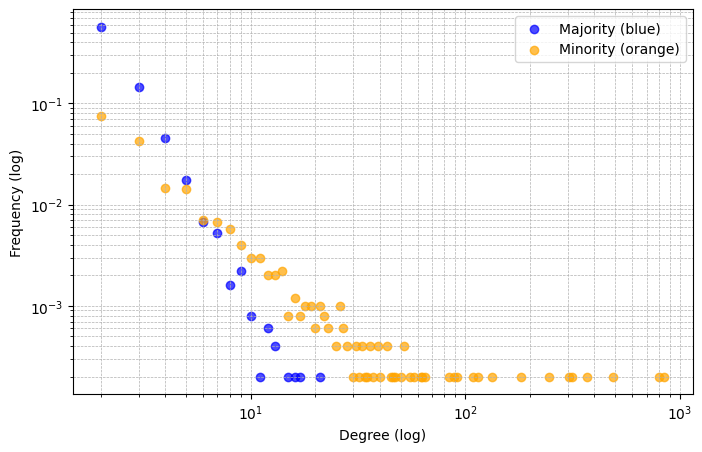

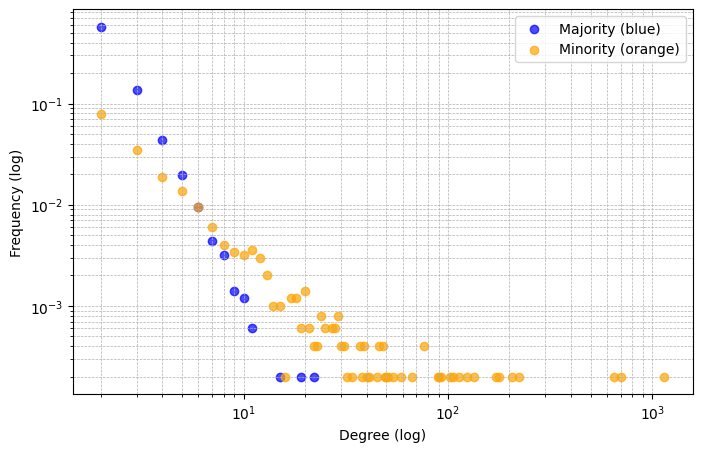

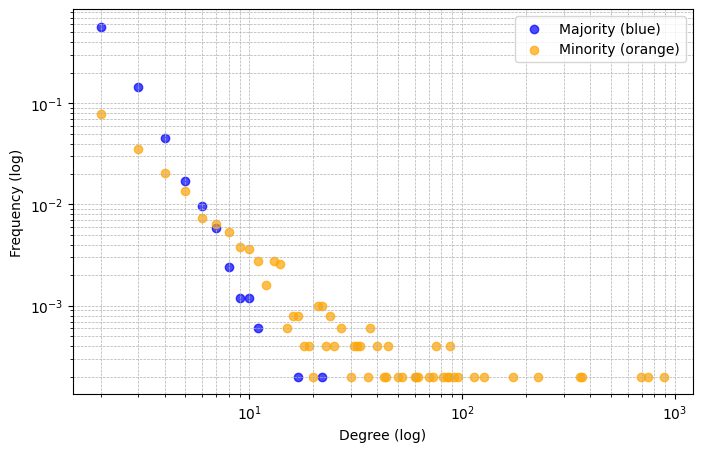

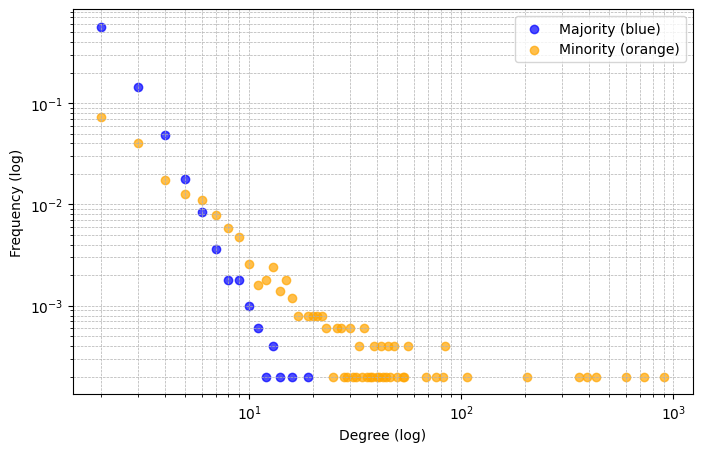

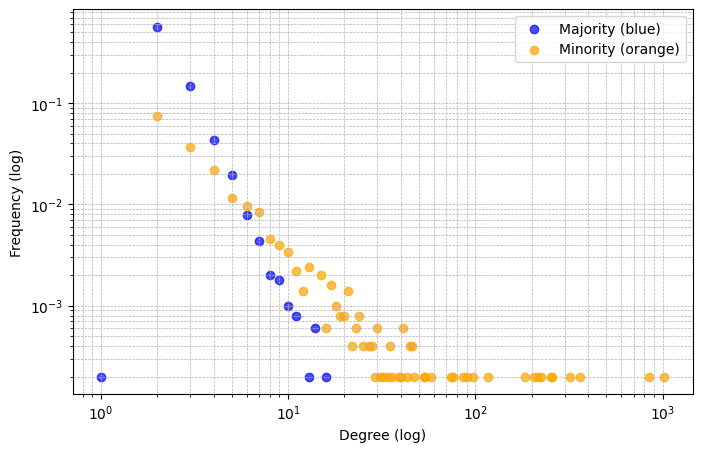

In [10]:
for i, G in enumerate(graphs0):

    plot_frequency_distribution(G)


## Average

In [11]:
def plot_average_degree_distribution(graphs):
    total_red_dist = defaultdict(int)
    total_blue_dist = defaultdict(int)

    for G in graphs:
        degrees = dict(G.degree())
        red_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'red']
        blue_degrees = [degrees[n] for n in G.nodes if G.nodes[n]['color'] == 'blue']
        
        red_dist = Counter(red_degrees)
        blue_dist = Counter(blue_degrees)

        for k, v in red_dist.items():
            total_red_dist[k] += v
        for k, v in blue_dist.items():
            total_blue_dist[k] += v

    num_graphs = len(graphs)
    avg_red_dist = {k: v / num_graphs for k, v in total_red_dist.items()}
    avg_blue_dist = {k: v / num_graphs for k, v in total_blue_dist.items()}

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(avg_blue_dist.items())), label='Majority (blue)', alpha=0.7, color='blue')
    plt.scatter(*zip(*sorted(avg_red_dist.items())), label='Minority (orange)', alpha=0.7, color='orange')
    plt.xlabel("Degree (log)")
    plt.ylabel("Average Number of Nodes (log)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

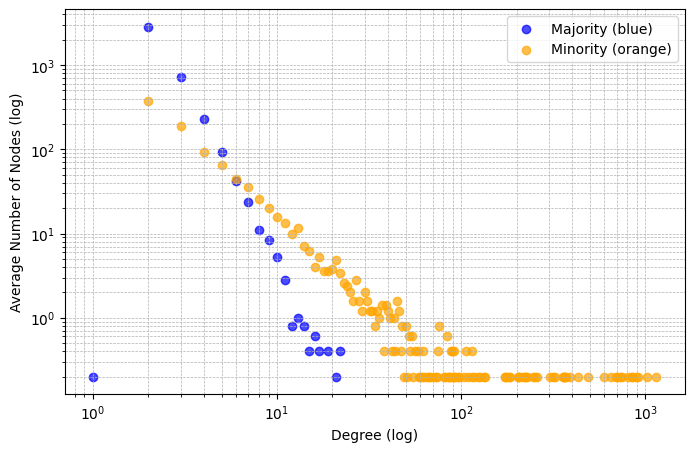

In [12]:
plot_average_degree_distribution(graphs0)

In [13]:

def average_frequency_distribution(graphs, title=None, savefile=None):
    red_freq = defaultdict(list)
    blue_freq = defaultdict(list)

    for G in graphs:
        degrees = dict(G.degree())

        red_nodes = [n for n in G.nodes if G.nodes[n]["color"] == "red"]
        blue_nodes = [n for n in G.nodes if G.nodes[n]["color"] == "blue"]

        red_degrees = [degrees[n] for n in red_nodes]
        blue_degrees = [degrees[n] for n in blue_nodes]

        red_dist = Counter(red_degrees)
        blue_dist = Counter(blue_degrees)

        red_total = len(red_nodes)
        blue_total = len(blue_nodes)
        total = red_total + blue_total 

        for k, v in red_dist.items():
            red_freq[k].append(v / total)
        for k, v in blue_dist.items():
            blue_freq[k].append(v / total)

    # Average frequencies across all graphs
    avg_red = {k: np.mean(v) for k, v in red_freq.items()}
    avg_blue = {k: np.mean(v) for k, v in blue_freq.items()}

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(*zip(*sorted(avg_blue.items())), label='Majority (blue)', color='blue', alpha=0.7)
    plt.scatter(*zip(*sorted(avg_red.items())), label='Minority (orange)', color='orange', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.xscale("log")
    plt.yscale("log")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(savefile, dpi=300)
    plt.show()
    plt.close()
    return avg_red, avg_blue

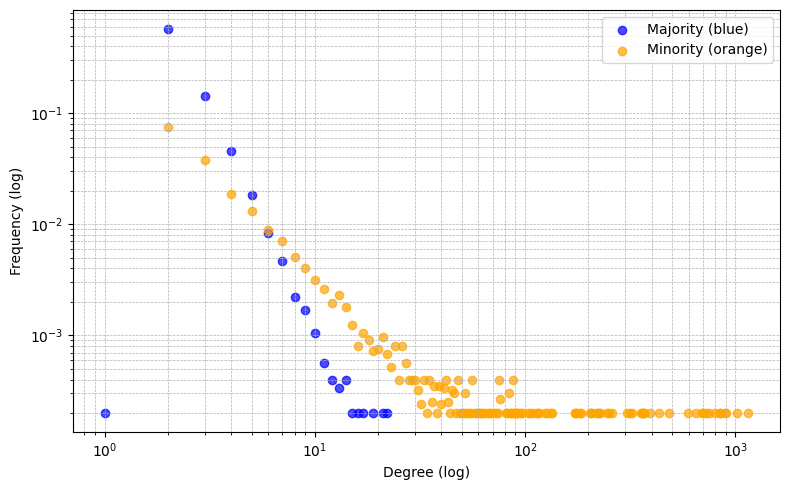

({804: 0.0002,
  0: 0.0002,
  848: 0.0002,
  486: 0.0002,
  314: 0.0002,
  305: 0.0002,
  115: 0.0002,
  133: 0.0002,
  369: 0.0002,
  17: 0.00104,
  245: 0.0002,
  84: 0.00030000000000000003,
  182: 0.0002,
  26: 0.0007999999999999999,
  65: 0.0002,
  92: 0.0002,
  43: 0.00025,
  58: 0.0002,
  8: 0.0051199999999999996,
  9: 0.004,
  18: 0.0009,
  25: 0.0004,
  33: 0.0004,
  109: 0.0002,
  31: 0.0003200000000000001,
  50: 0.0002,
  21: 0.0009599999999999999,
  89: 0.0002,
  47: 0.0002,
  46: 0.00030000000000000003,
  13: 0.00232,
  45: 0.00032,
  6: 0.008879999999999999,
  5: 0.013119999999999998,
  32: 0.00024000000000000003,
  7: 0.007079999999999999,
  22: 0.00068,
  62: 0.0002,
  19: 0.0007199999999999999,
  52: 0.00030000000000000003,
  39: 0.00035000000000000005,
  15: 0.00124,
  11: 0.0026400000000000004,
  36: 0.00025,
  14: 0.0018,
  28: 0.0004,
  55: 0.0002,
  27: 0.00056,
  63: 0.0002,
  30: 0.0004,
  34: 0.0002,
  3: 0.0378,
  37: 0.00035000000000000005,
  10: 0.00315999999

In [14]:
average_frequency_distribution(graphs0)

All homophily value with 20 trials 

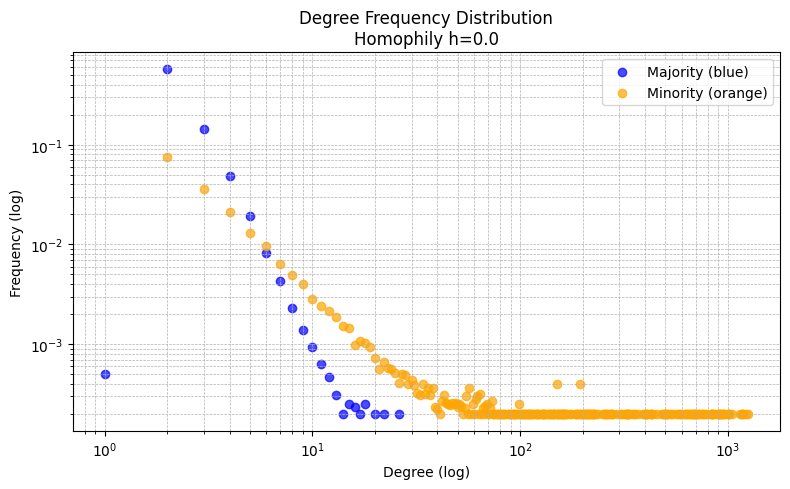

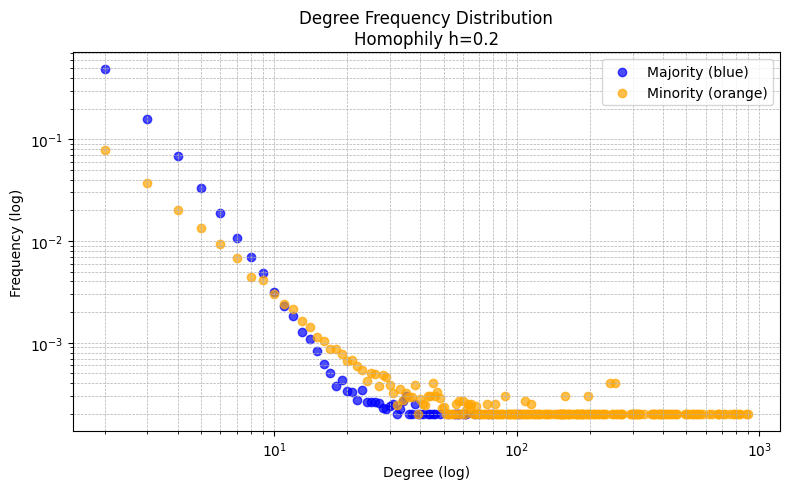

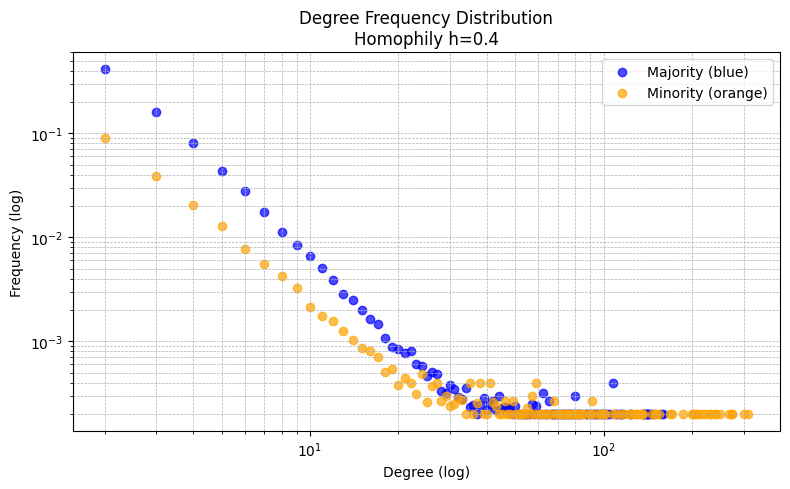

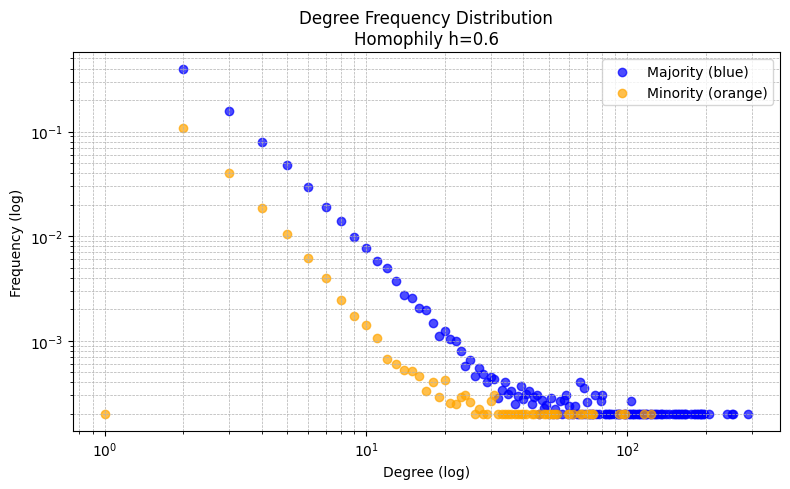

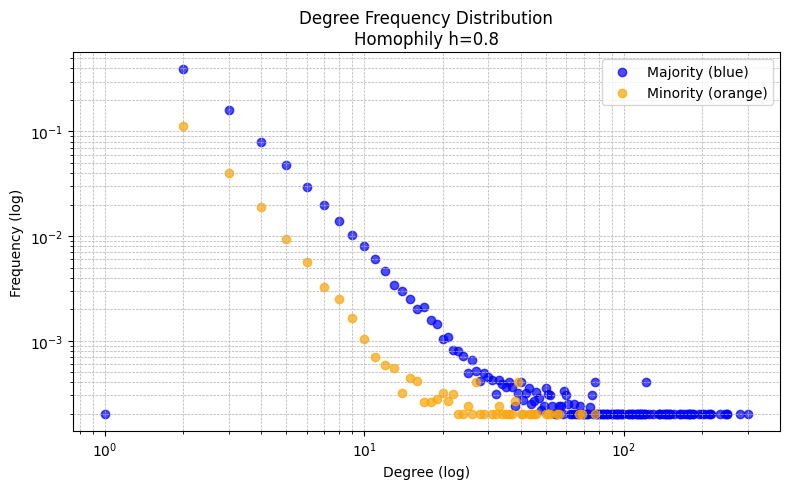

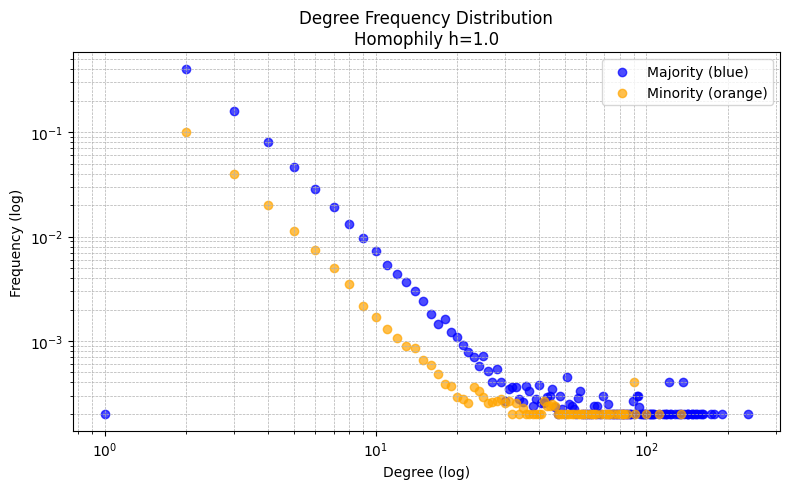

All plots saved.


In [15]:
# Parameters
homophily_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
num_trials = 20
seed_start = 145
seeds = list(range(seed_start, seed_start + num_trials))

# Loop over homophily values
for h in homophily_values:
    graphs = []
    for seed in seeds:
        G = homophilic_ba_graph(N=5000, m=2, minority_fraction=0.2, homophily=h, seed=seed)  # <-- use your graph generator
        graphs.append(G)
    title = f"Degree Frequency Distribution\nHomophily h={h}"
    savefile = f"degree_freq_h_{h:.1f}.png"
    average_frequency_distribution(graphs, title=title, savefile=savefile)

print("All plots saved.")
